---
title: "Support Vector Machines"
author: "phonchi"
date: "11/28/2022"
format: 
  html:
    toc: true
    code-line-numbers: true
    code-tools: true
---

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_9_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_9_Lab.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br/>

## Setup

`SVC`, `NuSVC` and `LinearSVC` are classes capable of performing binary and multi-class classification on a dataset. `SVC` and `NuSVC` are similar methods, but accept slightly different sets of parameters and have different mathematical formulations. On the other hand, `LinearSVC` is another (faster) implementation of Support Vector Classification for the case of a linear kernel. Note that LinearSVC does not accept parameter kernel, as this is assumed to be linear. It also lacks some of the attributes of `SVC` and `NuSVC`, like `support_`.

A `C` argument allows us to specify the cost of
a violation to the margin.  When the `C` argument is small,
then the margins will be wide and many support vectors will be on the
margin or will violate the margin.  When the `C` argument is
large, then the margins will be narrow and there will be few support
vectors on the margin or violating the margin.

In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV

from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#plt.style.use('seaborn-white')
plt.style.use('seaborn') # pretty matplotlib plots
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Support Vector Classifier

We now use the function to fit the support vector classifier for a given value of the `C` parameter.
Here we demonstrate the use of this function on a two-dimensional example so that we can plot the resulting decision boundary. We begin by generating
the observations, which belong to two classes, and checking whether the classes are linearly separable.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0, 0.5, 'X2')

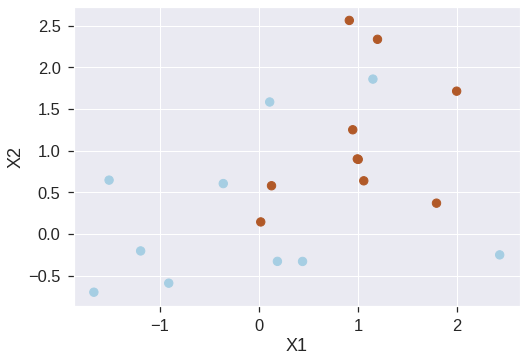

In [3]:
# Generating random data: 20 observations of 2 features and divide into two classes.
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([-1,1], 10)

X[y == 1, :] += 1
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

In [4]:
svc_clf = SVC(kernel='linear', C=10)
svc_clf.fit(X, y)

SVC(C=10, kernel='linear')

The region of feature space that will be assigned to the −1 class is shown in light blue, and the region that will be assigned to the +1 class is shown in
brown. The decision boundary between the two classes is linear (because we used the argument `kernel="linear`).

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


Number of support vectors:  13


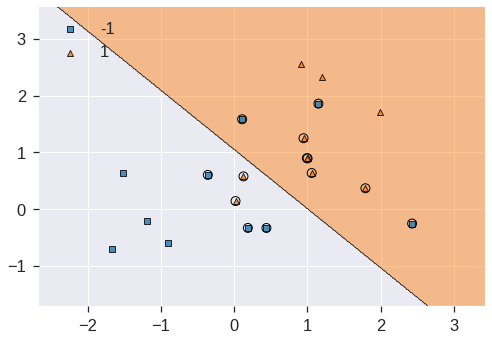

In [5]:
plot_decision_regions(X, y, clf=svc_clf, X_highlight=svc_clf.support_vectors_, legend=2)
print('Number of support vectors: ', svc_clf.support_.shape[0])

We see here that there are 13 support vectors. We can determine their identities as follows:

In [6]:
# get support vectors
pd.DataFrame(svc_clf.support_vectors_, index=svc_clf.support_)

,0,1
0,0.441227,-0.330870
1,2.430771,-0.252092
2,0.109610,1.582481
4,0.187603,-0.329870
6,-0.358829,0.603472
8,1.151391,1.857331
10,0.019392,0.143147
11,0.128121,0.577492
13,1.059144,0.636689
14,1.003289,0.894070


In [7]:
# get indices of support vectors
svc_clf.support_

array([ 0,  1,  2,  4,  6,  8, 10, 11, 13, 14, 15, 16, 17], dtype=int32)

In [8]:
# get number of support vectors for each class
svc_clf.n_support_

array([6, 7], dtype=int32)

What if we instead used a smaller value of the `C` parameter?

Number of support vectors:  16


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


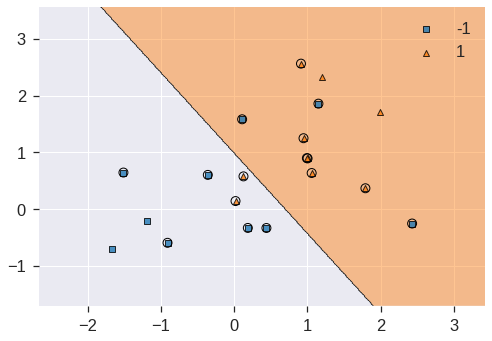

In [9]:
svc_clf2 = SVC(kernel='linear', C=0.1)
svc_clf2.fit(X, y)

plot_decision_regions(X, y, clf=svc_clf2, X_highlight=svc_clf2.support_vectors_)
print('Number of support vectors: ', svc_clf2.support_.shape[0])

Now that a smaller value of the `C` parameter is being used, we obtain a
larger number of support vectors, because the margin is now **wider**.

We now perform CV to determine the optimal value of `C`:

In [10]:
k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

svc_clf3 = SVC(kernel='linear')
c_space = np.array([0.001, 0.01, 0.1, 1, 5, 10, 100])
param_grid = {'C': c_space}

tune = GridSearchCV(svc_clf3, param_grid, cv=kf5)
tune.fit(X, y)

print(tune.best_params_)
pd.DataFrame(tune.cv_results_)

{'C': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000982,0.000299,0.000763,0.000544,0.001,{'C': 0.001},0.75,0.75,0.25,0.25,0.75,0.55,0.244949,6
1,0.000736,0.000125,0.000371,0.000064,0.01,{'C': 0.01},0.75,0.75,0.25,0.25,0.75,0.55,0.244949,6
2,0.000595,0.000018,0.000331,0.000020,0.1,{'C': 0.1},0.75,0.75,0.75,1.00,0.50,0.75,0.158114,1
3,0.000583,0.000026,0.000328,0.000016,1.0,{'C': 1.0},0.75,0.75,0.50,1.00,0.50,0.70,0.187083,2
4,0.000604,0.000034,0.000342,0.000028,5.0,{'C': 5.0},0.75,0.75,0.50,1.00,0.50,0.70,0.187083,2
5,0.000690,0.000087,0.000394,0.000139,10.0,{'C': 10.0},0.75,0.75,0.50,1.00,0.50,0.70,0.187083,2
6,0.000700,0.000021,0.000340,0.000011,100.0,{'C': 100.0},0.75,0.75,0.50,0.50,0.50,0.60,0.122474,5


`C=0.1` is best according to `GridSearchCV`. 

As usual, the `predict()` function can be used to predict the class label on a set of
test observations, at any given value of the `C` parameter. Let's generate a test data set:

In [11]:
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = resample(np.concatenate((np.ones(10, dtype=np.int64)*-1, np.ones(10, dtype=np.int64))),
                  replace=True,
                  n_samples=20, random_state=1)
X_test[y_test == 1, :] += 1

In [12]:
y_pred = tune.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=tune.classes_, columns=tune.classes_)

,-1,1
-1,7,2
1,1,10


Thus, with this value of `C`, 17 of the test observations are correctly classified.
What if we had instead used `C = 10`?

In [13]:
svc_clf4 = SVC(C=10, kernel='linear')
svc_clf4.fit(X, y)
y_pred = svc_clf4.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc_clf4.classes_, columns=svc_clf4.classes_)

,-1,1
-1,7,2
1,4,7


In this case three additional observations are misclassified.

Now consider a situation in which the two classes are linearly separable. Then we can
find a separating hyperplane using the `SVC()` function.
We first further separate the two classes in our simulated data so that they are linearly separable:

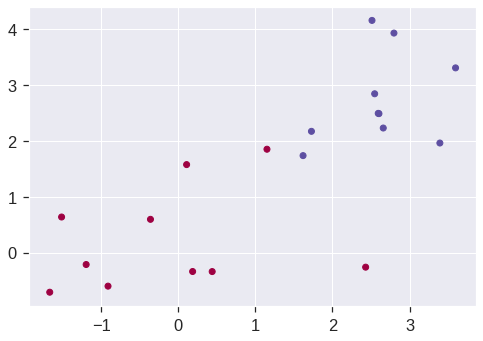

In [14]:
X[y == 1, :] += 1.6
plt.scatter(X[:, 0], X[:, 1], c=(y+5)/2, cmap='Spectral')

Now the observations are **just barely linearly** separable. We fit the support vector classifier and plot the resulting hyperplane, using a very large value
of `C` so that no observations are misclassified.

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


Number of support vectors:  3


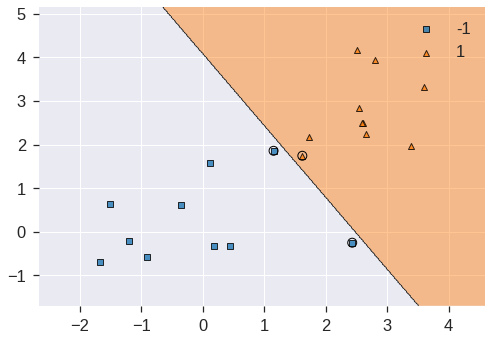

In [15]:
svc_clf5 = SVC(kernel='linear', C=1e5)
svc_clf5 .fit(X, y)

plot_decision_regions(X, y, clf=svc_clf5, X_highlight=svc_clf5.support_vectors_)
print('Number of support vectors: ', svc_clf5.support_.shape[0])

No training errors were made and only three support vectors were used.
However, we can see from the figure that the margin is very narrow (because
the observations that are **not** support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform
poorly on test data. Let's try a smaller value of `C`:

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


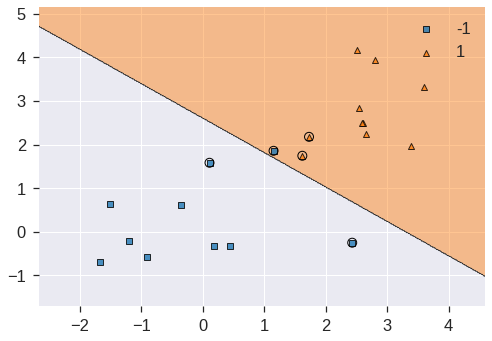

In [16]:
svc_clf6 = SVC(kernel='linear', C=1)
svc_clf6.fit(X, y)

plot_decision_regions(X, y, clf=svc_clf6, X_highlight=svc_clf6.support_vectors_)

Using `C=1`, we misclassify a training observation, but we also obtain a much wider margin and make use of five support vectors. It seems
likely that this model will perform better on test data than the model with `C`.

## The Kernel Method

In [17]:
from sklearn.datasets import make_circles

def feature_map_1(X):  
    return np.asarray((np.sqrt(2)*X[:,0]*X[:,1], X[:,0]**2, X[:,1]**2)).T

def my_kernel_1(X,Y):
    return np.dot(feature_map_1(X),feature_map_1(Y).T )

w= [-0.05481854 -2.53191791 -2.52028513] b= [1.14976292]


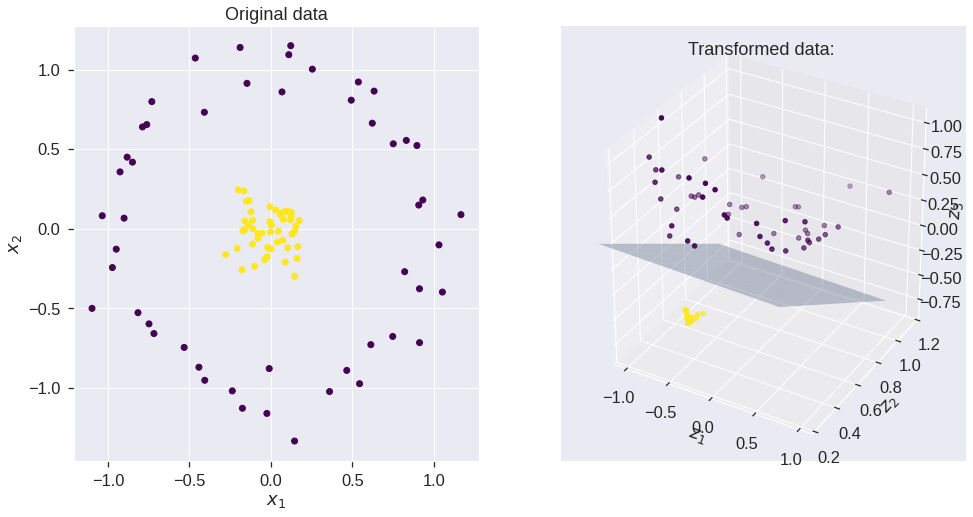

In [18]:
## Reference https://xavierbourretsicotte.github.io/Kernel_feature_map.html

X, y = make_circles(100, factor=.1, noise=.1, random_state = 0)
Z = feature_map_1(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original data')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed data: ')

#SVM using linear kernel with feature map 1
clf = SVC(C = 1, kernel = 'linear')
clf.fit(Z, y) 

w = clf.coef_.flatten()
b = clf.intercept_.flatten()
print('w=',w,'b=',b)

# create x,y
xx, yy = np.meshgrid(np.linspace(-1,1), np.linspace(0,1))

# calculate corresponding z
# The equation of the separating plane is given by all x in R^3 such that:
# np.dot(w, x) + b = 0. We should solve for the last coordinate
boundary = (-w[0] * xx - w[1] * yy - b) * 1. /w[2]


# plot the surface

ax.plot_surface(xx, yy, boundary, alpha = .3)
ax.set_ylim(.2,1.2)
ax.set_zlim(-.9,1.1)
#ax.view_init(0, 260)

plt.show()

In [19]:
#SVM using kernel 1 - feature map 1
clf2 = SVC(kernel=my_kernel_1)
clf2.fit(X, y) 

# predict on training examples - print accuracy score
print('Accuracy score using feature map ',accuracy_score(y, clf2.predict(X)))
print('Accuracy score using feature map ',accuracy_score(y, clf.predict(Z)))

Accuracy score using feature map  1.0
Accuracy score using feature map  1.0


Text(0, 0.5, '$x_2$')

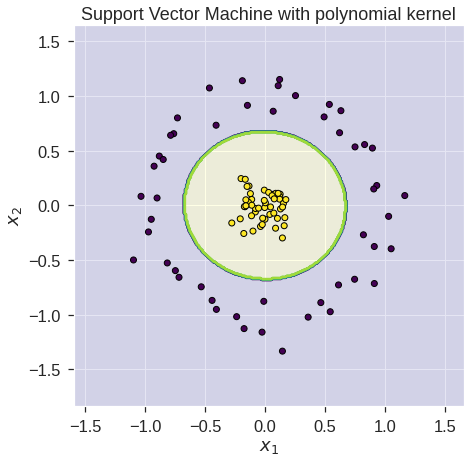

In [20]:
#Initialize data
h = .01 #Stepsize in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on meshgrid
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (7,7))
plt.contourf(xx, yy, Z, 1, colors = ['darkblue','yellow'], alpha = .1) # plot coutour surface
plt.contour(xx, yy, Z, cmap = 'viridis') # plot coutour line

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors = 'k')
plt.title('Support Vector Machine with polynomial'
          ' kernel')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## Support Vector Machine

In order to fit an SVM using a **non-linear kernel**, we once again use the `SVC()` function. However, now we use a different value of the parameter kernel.
To fit an SVM with a polynomial kernel we use `kernel="poly"`, and to fit an SVM with a radial kernel we use `kernel="rbf"`. In the former case we also use the `degree` argument to specify a degree for the polynomial kernel, and in the latter case we use $\gamma$ to specify a value of $\gamma$ for the radial basis kernel.

Let's generate some data with a non-linear class boundary:

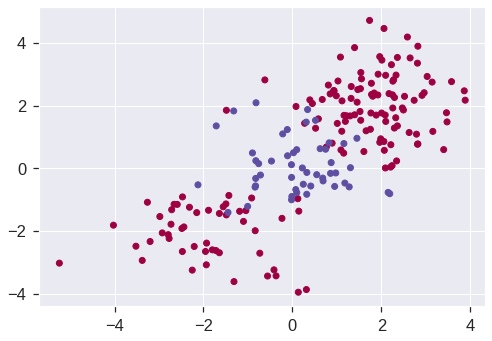

In [21]:
np.random.seed(42)

X = np.random.normal(size=400).reshape(200, 2)
X[0:100, :] += 2
X[100:150, :] -= 2
y = np.concatenate((np.full(150, -1, dtype=np.int64), np.full(50, 1, dtype=np.int64)))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=1)

See how one class is kind of stuck in the middle of another class? This suggests that we might want to use a **radial kernel** in our SVM. Now let's fit
the training data using the `SVC()` function with a radial kernel and $\gamma = 1$:

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


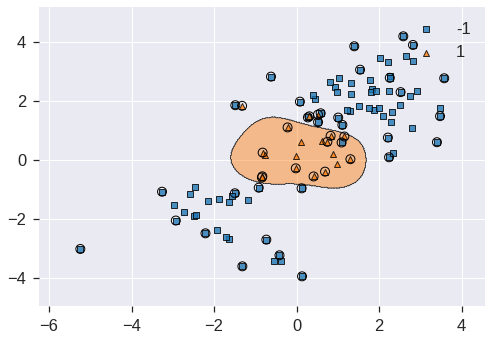

In [23]:
svm = SVC(kernel='rbf', gamma=1, C=1)
svm.fit(X_train, y_train)

plot_decision_regions(X_train, y_train, clf=svm, X_highlight=svm.support_vectors_);

Not too shabby! The plot shows that the resulting SVM has a decidedly non-linear boundary. We can see from the figure that there are a fair number of training errors
in this SVM fit. If we increase the value of `C`, we can reduce the number of training errors:

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


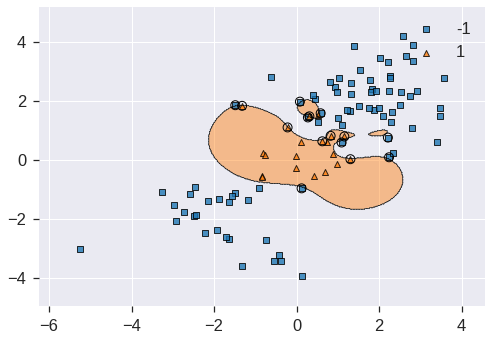

In [24]:
svm2 = SVC(kernel='rbf', gamma=1, C=1e5)
svm2.fit(X_train, y_train)

plot_decision_regions(X_train, y_train, clf=svm2, X_highlight=svm2.support_vectors_)

However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data. We can perform cross-validation using `GridSearchCV()` to select the best choice of $\gamma$ and cost for an SVM with a radial kernel:

In [25]:
svm3 = SVC(kernel='rbf')
c_space = np.array([0.1, 1, 10, 100, 1000])
g_space = np.array([0.5, 1, 2, 3, 4])
param_grid = {'C': c_space, 'gamma': g_space}

tune = GridSearchCV(svm3, param_grid, cv=10)
tune.fit(X_train, y_train)

tune.cv_results_
tune.best_params_

{'C': 1.0, 'gamma': 0.5}

Therefore, the best choice of parameters involves `C=1` and `gamma=0.5`. We
can view the test set predictions for this model by applying the `predict()` function to the test data:

In [26]:
y_pred = tune.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=tune.classes_, columns=tune.classes_)

,-1,1
-1,67,3
1,9,21


$12\,\%$ of test observations are misclassified by this SVM.

## ROC Curves

The `roc_curve` and `auc()` function from the `sklearn.metrics` package can be used to produce ROC curves such as those we saw in lecture:

In [27]:
def plot_roc(cls,X,y,title):
    probs = cls.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y,probs)
    auc = roc_auc_score(y,probs)
    
    plt.figure(figsize = (6,6))
    plt.plot(fpr,tpr,label="auc="+str(auc)[0:4],c = 'r')
    plt.plot([0,1],[0,1],alpha = 0.1,c = 'b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

SVMs and support vector classifiers output class labels for each observation. However, it is also possible to obtain *fitted values* for each observation, which are the numerical scores used to obtain the class labels. For instance, in the case of a support vector
classifier, the fitted value for an observation $X= (X_1, X_2, \ldots, X_p)^T$ takes the form $\hat{\beta}_0 + \hat{\beta}_1 X_1 + \hat{\beta}_2 X_2 + \cdots + \hat{\beta}_p X_p$. For an SVM with a non-linear kernel, the equation that yields the fitted value is given in (9.23). In essence, the sign of the fitted value determines on which side of the decision boundary the observation lies. Therefore, the relationship between the fitted value and the class prediction for a given observation is simple: if the fitted value exceeds zero then the observation is assigned to one class, and if it is less than zero then it is assigned to the other. Then the `predict()` function will output the fitted values.

Let's start by fitting two models, one more flexible than the other:

In [28]:
# More constrained model
svm4 = SVC(kernel='rbf', gamma=2, C=1, probability=True)
svm4.fit(X_train, y_train)

# More flexible model
svm5 = SVC(kernel='rbf', gamma=50, C=1, probability=True)
svm5.fit(X_train, y_train)

SVC(C=1, gamma=50, probability=True)

SVM appears to be producing accurate predictions. By increasing $\gamma$ we can produce a more flexible fit and generate further improvements in accuracy.

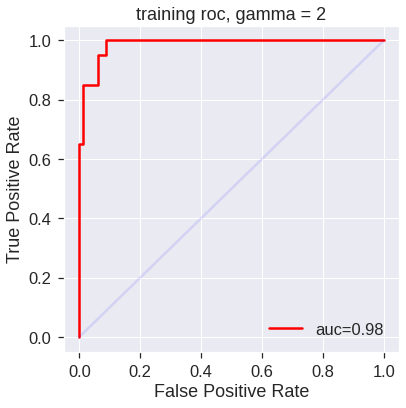

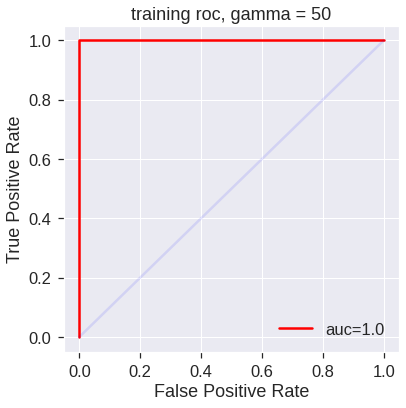

In [29]:
plot_roc(svm4,X_train,y_train,'training roc, gamma = 2')
plot_roc(svm5,X_train,y_train,'training roc, gamma = 50')

However, these ROC curves are all on the training data. We are really more interested in the level of prediction accuracy on the test data. When we compute the ROC curves on the test data, the model with $\gamma=2$ appears to provide the most accurate results.

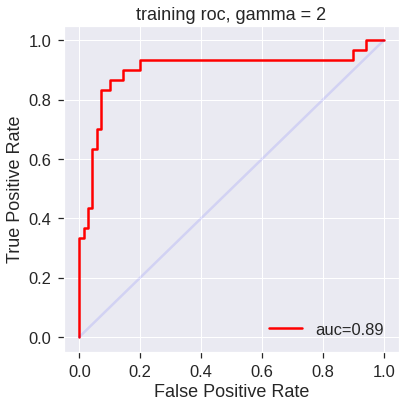

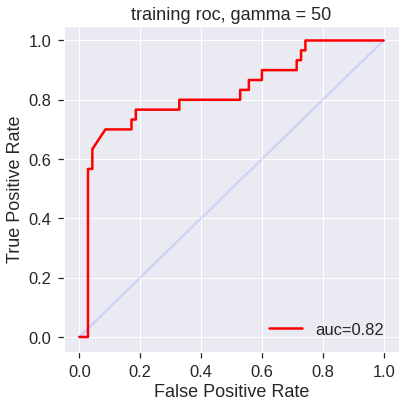

In [30]:
plot_roc(svm4,X_test,y_test,'training roc, gamma = 2')
plot_roc(svm5,X_test,y_test,'training roc, gamma = 50')

## SVM with Multiple Classes

If the response is a factor containing more than two levels, then the `svm()` function will  perform multi-class classification using the one-versus-all approach. We explore that setting here by generating a third class of observations.

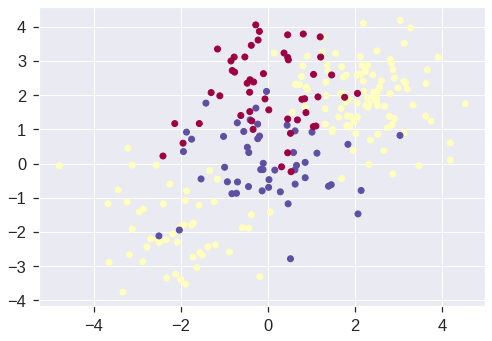

In [31]:
np.random.seed(1)

X = np.random.normal(size=400).reshape(200, 2)
X[0:100, :] += 2
X[100:150, :] -= 2
y = np.concatenate((np.full(150, 1, dtype=np.int64), np.full(50, 2, dtype=np.int64)))

X = np.concatenate((X, np.random.normal(size=100).reshape(50, 2)))
y = np.concatenate((y, np.full(50, 0, dtype=np.int64)))

X[y == 0, 1] += 2

plt.scatter(X[:, 0], X[:, 1], c=y+1, cmap='Spectral');

We now fit an SVM to the data:

0.868


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


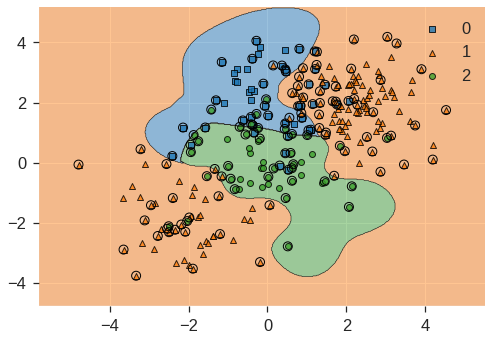

In [32]:
svm_m = SVC(kernel='rbf', C=10, gamma=1, decision_function_shape='ovr')
svm_m.fit(X, y)
print(svm_m.score(X, y))
plot_decision_regions(X, y, clf=svm_m, X_highlight=svm_m.support_vectors_)

## Application to Gene Expression Data

We now examine the `Khan` data set, which  consists of a number of tissue samples corresponding to four distinct types of small round blue cell tumors. For each tissue sample, gene expression measurements are available.
The data set consists of training data, `xtrain` and `ytrain`, and testing data, `xtest` and `ytest`.

In [35]:
khan_X_train = pd.read_csv('/content/drive/MyDrive/Lab/Data/Khan_xtrain.csv', index_col=0)
khan_y_train = pd.read_csv('/content/drive/MyDrive/Lab/Data/Khan_ytrain.csv', index_col=0)
khan_X_test = pd.read_csv('/content/drive/MyDrive/Lab/Data/Khan_xtest.csv', index_col=0)
khan_y_test = pd.read_csv('/content/drive/MyDrive/Lab/Data/Khan_ytest.csv', index_col=0)

We examine the dimension of the data:

In [36]:
khan_X_train.shape, khan_X_test.shape, len(khan_y_train), len(khan_y_test)

((63, 2308), (20, 2308), 63, 20)

This data set consists of expression measurements for $2{,}308$  genes.  The training and test sets consist of $63$ and $20$ observations respectively.

We will use a support vector approach to predict cancer subtype using gene expression measurements.
In this data set, there are a very large number of  features relative to the number of observations. This suggests that we should use a  linear kernel, because the additional flexibility that will result from using a polynomial or radial kernel is unnecessary. 

In [37]:
khan_y_train.iloc[:, 0].value_counts(sort=False)

2    23
4    20
3    12
1     8
Name: x, dtype: int64

In [38]:
khan_y_test.iloc[:, 0].value_counts(sort=False)

3    6
2    6
4    5
1    3
Name: x, dtype: int64

In [39]:
gene_clf = SVC(kernel='linear', C=10)
gene_clf.fit(khan_X_train, khan_y_train.iloc[:, 0])

khan_y_train_pred = gene_clf.predict(khan_X_train)

pd.DataFrame(confusion_matrix(khan_y_train_pred, khan_y_train), index=gene_clf.classes_, columns=gene_clf.classes_)

,1,2,3,4
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


We  see that there are *no* training errors. In fact, this is not surprising, because
the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate the classes. We are most interested not in the support vector classifier's performance on the training observations, but rather its performance on the test observations.

In [40]:
khan_y_test_pred = gene_clf.predict(khan_X_test)
pd.DataFrame(confusion_matrix(khan_y_test_pred, khan_y_test), index=gene_clf.classes_, columns=gene_clf.classes_)

,1,2,3,4
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


We see that using `C = 10` yields two test set errors on this data.

## SGD Classifier

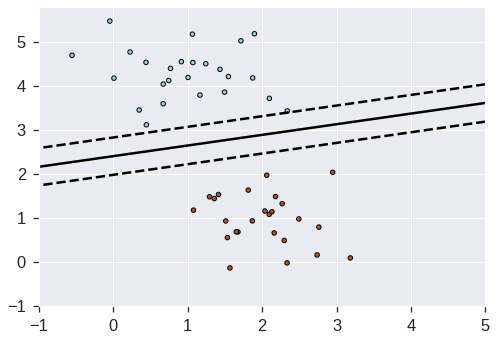

In [41]:
from sklearn.datasets import make_blobs

# we create 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)

clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolor="black", s=20)

plt.axis("tight")
plt.show()

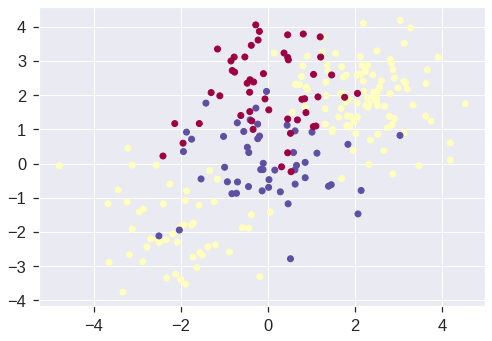

In [42]:
np.random.seed(1)

X = np.random.normal(size=400).reshape(200, 2)
X[0:100, :] += 2
X[100:150, :] -= 2
y = np.concatenate((np.full(150, 1, dtype=np.int64), np.full(50, 2, dtype=np.int64)))

X = np.concatenate((X, np.random.normal(size=100).reshape(50, 2)))
y = np.concatenate((y, np.full(50, 0, dtype=np.int64)))

X[y == 0, 1] += 2

plt.scatter(X[:, 0], X[:, 1], c=y+1, cmap='Spectral');

In [43]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X)
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)
clf.fit(X_features, y)
clf.score(X_features, y)

0.84